## Iowa Housing Prices

Team Name: Drop a Feature Like its Hot

Team Members:
- Mohamad Sayed
- Andrew Hoffman
- Yasuhiro Shinohara


#### Importing packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import sklearn.model_selection as ms
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, make_scorer

In [2]:
df_test = pd.read_csv("output_df_test.csv")
df_train = pd.read_csv("output_df_train.csv")

In [3]:
# Drop Id column
df_test_Id = pd.read_csv("output_df_test.csv").Id
df_train = df_train.drop('Id', axis = 1)
df_test = df_test.drop('Id', axis = 1)

# Dummify columns
df_train = pd.get_dummies(df_train, drop_first = True)
df_test = pd.get_dummies(df_test, drop_first = True)

# Splitting SalePrice from train set; X without SalePrice and Y is only SalePrice of train set
X = df_train.loc[:, df_train.columns !='SalePrice']
Y = np.log(df_train[['SalePrice']])

# Split the train and test data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

#  Cross validation for 5-folds
cv5 = KFold(n_splits = 5, random_state = 1, shuffle = True)



In [4]:
# Xgboost
from xgboost import XGBRegressor, XGBClassifier

xgb = XGBRegressor()
xgb.set_params(random_state = 123)
xgb.fit(X, Y)

xgb_param_grid = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
                           'n_estimators' : range(500, 1000, 50),
                            'max_depth' : range(2,6),
                            'min_child_weight' : range(4,8)
                           }

random_search_xgb_5 = RandomizedSearchCV(xgb, xgb_param_grid, scoring='neg_mean_squared_error', 
                                     cv= cv5, n_jobs=-1, return_train_score = True)

random_search_xgb_5.fit(X, Y)

xgb_random5 = random_search_xgb_5.best_estimator_

xgb_prediction_random = xgb_random5.predict(X_test)

xgb_ytest = xgb_random5.predict(df_test)

xgb_ytest

[23:01:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:03:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([11.70576  , 11.9659395, 12.142884 , ..., 11.990751 , 11.690765 ,
       12.368181 ], dtype=float32)

In [5]:
# Lasso & Ridge
from sklearn.linear_model import Ridge, Lasso

# # Ridge
# ridge = Ridge()
# ridge.set_params(alpha = -12, normalize = True)
# ridge.fit(x,y)
# ridge_answer = np.expm1( ridge.predict(testX) ) # UNRELIABLE!!!

# Lasso
lasso = Lasso()
lasso.set_params(alpha = 0.000236, normalize = True)
lasso.fit(X,Y)
lasso_answer = np.expm1(lasso.predict(df_test) ) # Very Good!
lasso_answer

array([112062.25564032, 155046.5319203 , 173374.96375464, ...,
       176998.5295293 , 116030.53484114, 232074.54089465])

In [ ]:
# Stacking Lasso & Xgboost

df_test_Id = pd.read_csv("output_df_test.csv").Id
stacked_model = pd.DataFrame(data = ((0.5 * lasso_answer) + (0.5 * np.expm1(xgb_ytest))), columns = ['SalePrice'])

stacked_model = pd.concat([df_test_Id, stacked_model], axis = 1)
stacked_model.sample(10)

In [ ]:
stacked_model.to_csv('stacked_SalePrice.csv', index = False)

Kaggle Score: mse = 0.136

**Stacking Lasso & Xgboost & PCA**

In [30]:
# Importing PCA Predicted prices and converting to np.array

PCA_price = pd.read_csv("PCA_predicted_price.csv")
pca_price_array = np.array(PCA_price['SalePrice'])

In [36]:
# Stacking Lasso & Xgboost & PCA predicted values

full_stack = pd.DataFrame(data = (((1/3) * lasso_answer) + ((1/3) * np.expm1(xgb_ytest)) + (1/3)* pca_price_array), columns = ['SalePrice'])
full_stack = pd.concat([df_test_Id, full_stack], axis = 1)

In [37]:
full_stack.to_csv('full_stack_SalePrice.csv', index = False)

Kaggle Score: mse = 0.13999

##### Comparing Lasso to Xgboost 

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

In [34]:
# Creating DataFrame for each of Lasso & Xgboost SalePrice
xgboost_SalePrice = pd.DataFrame(np.expm1(xgb_ytest), columns = ['XGB_SalePrice'])
lasso_SalePrice = pd.DataFrame(lasso_answer, columns = ['Lasso_SalePrice'])
plot_lasso_xgboost = pd.concat([lasso_SalePrice, xgboost_SalePrice], axis = 1)

No handles with labels found to put in legend.


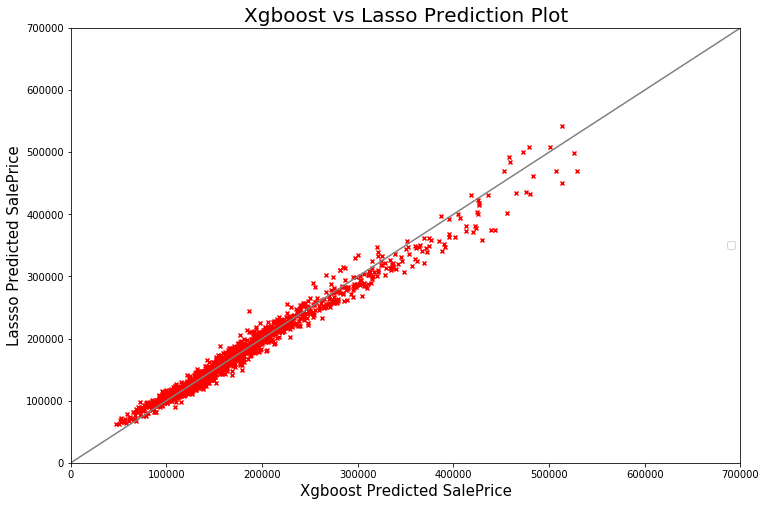

In [49]:
plt.figure(figsize = (12,8))
plt.scatter(np.expm1(xgb_ytest), lasso_answer, c='Red', s=16, marker="x")

plt.title("Xgboost vs Lasso Prediction Plot", fontsize = 20)

plt.xlabel("Xgboost Predicted SalePrice", fontsize = 15)
plt.ylabel("Lassso Predicted SalePrice", fontsize = 15)

plt.xlim(0, 700000)
plt.ylim(0, 700000)
plt.legend(loc = "center right")
plt.plot([0, 700000], [0, 700000], c = "grey")
plt.show()

##### Comparing PCA to Lasso

No handles with labels found to put in legend.


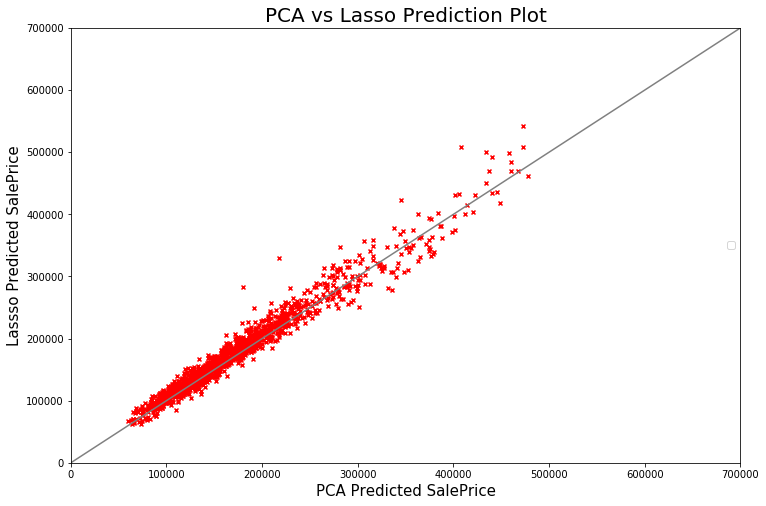

In [40]:
# Creating DataFrame for each of Lasso & PCA SalePrice

plt.figure(figsize = (12,8))
plt.scatter(pca_price_array, lasso_answer, c='Red', s=16, marker="x")

plt.title("PCA vs Lasso Prediction Plot", fontsize = 20)

plt.xlabel("PCA Predicted SalePrice", fontsize = 15)
plt.ylabel("Lassso Predicted SalePrice", fontsize = 15)

plt.xlim(0, 700000)
plt.ylim(0, 700000)
plt.legend(loc = "center right")
plt.plot([0, 700000], [0, 700000], c = "grey")
plt.show()

##### Comparing PCA to Xgboost 

No handles with labels found to put in legend.


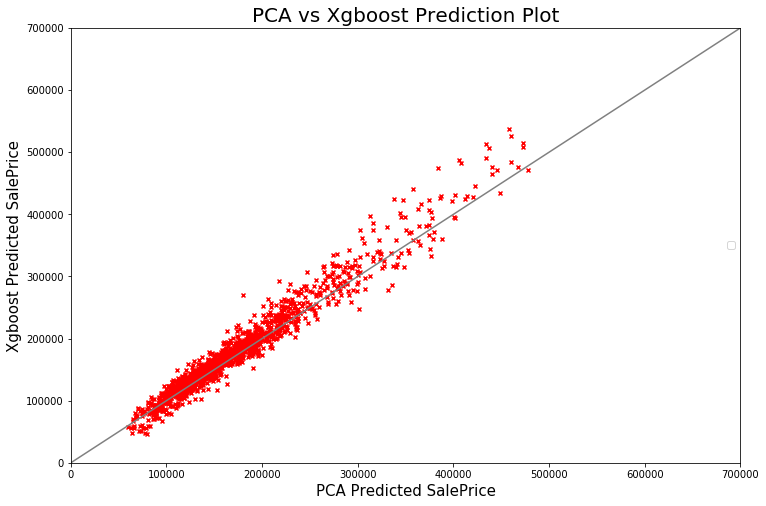

In [41]:
plt.figure(figsize = (12,8))
plt.scatter(pca_price_array, np.expm1(xgb_ytest), c='Red', s=16, marker="x")

plt.title("PCA vs Xgboost Prediction Plot", fontsize = 20)

plt.xlabel("PCA Predicted SalePrice", fontsize = 15)
plt.ylabel("Xgboost Predicted SalePrice", fontsize = 15)

plt.xlim(0, 700000)
plt.ylim(0, 700000)
plt.legend(loc = "center right")
plt.plot([0, 700000], [0, 700000], c = "grey")
plt.show()
